A quanto pare lo scopo finale sarà prevedere quali sono gli squareid con maggiori consumi. Quindi in questo script si cercano di unire i vari dati a disposizione (meteo, twitter, consumi etc) con il df df_grid che contiene gli quareid che compongono il trentino e la loro geometry

In [8]:
import pandas as pd
import geopandas as gpd
import numpy as np
from dateutil import parser
import matplotlib.pyplot as plt

import statistics

import json
from shapely.geometry import Point

import pickle

import time
import datetime

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [9]:
#pathlib permette di lavorare con directory in modo efficiente
from pathlib  import Path
#definisco directory data 
data_path = Path('../data/raw')
#definisco un dizionario così più semplice richiamare le robe
files = {'grid':'trentino-grid.geojson',
         'adm_reg':'administrative_regions_Trentino.json',
        'weather':'meteotrentino-weather-station-data.json',
        'precip':'precipitation-trentino.csv',
        'precip-avail':'precipitation-trentino-data-availability.csv',
        'SET-1':'SET-nov-2013.csv',
        'SET-2':'SET-dec-2013.csv',
        'SET-lines':'line.csv',
        'twitter':'social-pulse-trentino.geojson',
        'comuni':'Com01012022_g_WGS84.json',
        'province':'ProvCM01012022_g_WGS84.json',
        'regioni':'Reg01012022_g_WGS84.json',
        'appa':'APPA_inquinamento_aria_Nov_Dec_2013.csv'
        }

# Apro vari datasets


In [10]:
df_grid = gpd.read_file(data_path / files['grid'])
df_grid

,cellId,geometry
0,38,"POLYGON ((10.91462 45.68201, 10.92746 45.68179..."
1,39,"POLYGON ((10.92746 45.68179, 10.94029 45.68157..."
2,40,"POLYGON ((10.94029 45.68157, 10.95312 45.68136..."
3,154,"POLYGON ((10.90209 45.69122, 10.91493 45.69100..."
4,155,"POLYGON ((10.91493 45.69100, 10.92777 45.69079..."
...,...,...
6570,11336,"POLYGON ((11.80475 46.52767, 11.81777 46.52735..."
6571,11337,"POLYGON ((11.81777 46.52735, 11.83080 46.52703..."
6572,11452,"POLYGON ((11.79219 46.53698, 11.80521 46.53666..."
6573,11453,"POLYGON ((11.80521 46.53666, 11.81824 46.53634..."


<AxesSubplot:>

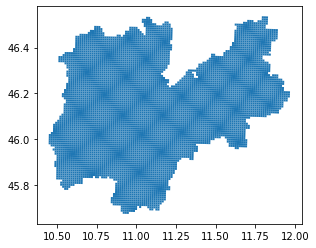

In [11]:
df_grid.plot() 

# Datasets dei consumi

SET-1 è per novembre

SET-2 è per dicembre

In [12]:
header = ['cell_id', 'date', 'corrente']
df_consuminov = pd.read_csv( data_path / files['SET-1'], names=header)
df_consumidic = pd.read_csv( data_path / files['SET-2'], names=header)

In [13]:
corr_nov_abs = [abs(e) for e in df_consuminov['corrente']]
corr_dic_abs = [abs(e) for e in df_consumidic['corrente']]

In [14]:
df_consuminov = df_consuminov.drop('corrente',axis=1).assign(corrente=corr_nov_abs)
df_consumidic = df_consumidic.drop('corrente',axis=1).assign(corrente=corr_dic_abs)

dataframe linee elettriche

In [15]:
df_linee = pd.read_csv( data_path / files['SET-lines'])
df_linee

,SQUAREID,LINESET,NR_UBICAZIONI
0,155,DG1031221,4
1,272,DG1031221,72
2,273,DG1031221,21
3,276,DG1003117,34
4,277,DG1003117,3
...,...,...,...
2570,10983,DG1013504,5
2571,10984,DG1013504,2
2572,11097,DG1013503,1
2573,11098,DG1013503,6


UNISCO CONSUMI DI NOVEMBRE A QUELLI DI DICEMBRE. 

Infatti useremo entrambi i datasets per fare considerazioni + regressione e classificazione.

In [16]:
df_consumi = pd.concat([df_consuminov, df_consumidic], ignore_index=True)
#ignore_index=True serve perchè altrimenti gli indici dei df iniziali vengono mantenuti

In [17]:
#splitto la colonna 'date' in due colonne: 'day' e 'time'

df_consumi[['day', 'time']] = df_consumi['date'].str.split(' ', 1, expand=True)
#df_consuminov = df_consuminov.drop('time', axis=1) --> questa riga serve per droppare la colonna con l'orario
df_consumi

,cell_id,date,corrente,day,time
0,DG1000420,2013-11-01 00:00,37.439999,2013-11-01,00:00
1,DG1000420,2013-11-01 00:10,37.439999,2013-11-01,00:10
2,DG1000420,2013-11-01 00:20,36.000000,2013-11-01,00:20
3,DG1000420,2013-11-01 00:30,35.279999,2013-11-01,00:30
4,DG1000420,2013-11-01 00:40,35.279999,2013-11-01,00:40
...,...,...,...,...,...
1615889,DG1056626,2013-12-31 23:10,79.574997,2013-12-31,23:10
1615890,DG1056626,2013-12-31 23:20,78.625000,2013-12-31,23:20
1615891,DG1056626,2013-12-31 23:30,77.025002,2013-12-31,23:30
1615892,DG1056626,2013-12-31 23:40,76.125000,2013-12-31,23:40


AGGIUNGO UNA COLONNA CON I TIMESTAMP IN df_consumi. I timestamp li genero considerando solo la colonna 'day' (no 'time')

In [18]:
#creo vettore vuoto timestamp a cui assegno valori uno alla volta nel ciclo for 
timestamp = []
for i in range(len(df_consumi)):
    s=df_consumi.day[i]    
    #timestamp.insert(i, time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d").timetuple()) )
    timestamp.insert(i, parser.parse(df_consumi.day[i]).timestamp())
    
series_timestamp = pd.Series(timestamp)
df_consumi = df_consumi.assign(timestamp=series_timestamp)

df_consumi

,cell_id,date,corrente,day,time,timestamp
0,DG1000420,2013-11-01 00:00,37.439999,2013-11-01,00:00,1.383260e+09
1,DG1000420,2013-11-01 00:10,37.439999,2013-11-01,00:10,1.383260e+09
2,DG1000420,2013-11-01 00:20,36.000000,2013-11-01,00:20,1.383260e+09
3,DG1000420,2013-11-01 00:30,35.279999,2013-11-01,00:30,1.383260e+09
4,DG1000420,2013-11-01 00:40,35.279999,2013-11-01,00:40,1.383260e+09
...,...,...,...,...,...,...
1615889,DG1056626,2013-12-31 23:10,79.574997,2013-12-31,23:10,1.388444e+09
1615890,DG1056626,2013-12-31 23:20,78.625000,2013-12-31,23:20,1.388444e+09
1615891,DG1056626,2013-12-31 23:30,77.025002,2013-12-31,23:30,1.388444e+09
1615892,DG1056626,2013-12-31 23:40,76.125000,2013-12-31,23:40,1.388444e+09


SOMMO NR_UBICAZIONI SULLE LINEE

In [19]:
#linee con le ubicazioni totali per linea

grouped_ub = df_linee.groupby("LINESET")['NR_UBICAZIONI'].sum()
df_grouped_ub=grouped_ub.to_frame().reset_index()
df_grouped_ub

,LINESET,NR_UBICAZIONI
0,DG1000011,6
1,DG1000023,62
2,DG1000420,2133
3,DG1000421,1424
4,DG1000422,3423
...,...,...
195,DG1099206,105
196,DG1099207,95
197,DG1099303,39
198,DG1099502,3


DIVIDO IN SETTIMANE IL DATAFRAME

In [20]:
#per novembre
mask1_n = (df_consumi['day'] >= '2013-11-04') & (df_consumi['day'] <= '2013-11-08')
set1_n = df_consumi.loc[mask1_n]

mask2_n = (df_consumi['day'] >= '2013-11-11') & (df_consumi['day'] <= '2013-11-15')
set2_n = df_consumi.loc[mask2_n]

mask3_n = (df_consumi['day'] >= '2013-11-18') & (df_consumi['day'] <= '2013-11-22')
set3_n = df_consumi.loc[mask3_n]

mask4_n = (df_consumi['day'] >= '2013-11-25') & (df_consumi['day'] <= '2013-11-29')
set4_n = df_consumi.loc[mask4_n]

#per dicembre
mask1_d = (df_consumi['day'] >= '2013-12-02') & (df_consumi['day'] <= '2013-12-06')
set1_d = df_consumi.loc[mask1_d]

mask2_d = (df_consumi['day'] >= '2013-12-09') & (df_consumi['day'] <= '2013-12-13')
set2_d = df_consumi.loc[mask2_d]

mask3_d = (df_consumi['day'] >= '2013-12-16') & (df_consumi['day'] <= '2013-12-20')
set3_d = df_consumi.loc[mask3_d]

mask4_d = (df_consumi['day'] >= '2013-12-23') & (df_consumi['day'] <= '2013-12-27')
set4_d = df_consumi.loc[mask4_d]

In [21]:
set1_n

,cell_id,date,corrente,day,time,timestamp
432,DG1000420,2013-11-04 00:00,31.319998,2013-11-04,00:00,1.383520e+09
433,DG1000420,2013-11-04 00:10,31.319998,2013-11-04,00:10,1.383520e+09
434,DG1000420,2013-11-04 00:20,30.059999,2013-11-04,00:20,1.383520e+09
435,DG1000420,2013-11-04 00:30,29.519999,2013-11-04,00:30,1.383520e+09
436,DG1000420,2013-11-04 00:40,29.519999,2013-11-04,00:40,1.383520e+09
...,...,...,...,...,...,...
791347,DG1056626,2013-11-08 23:10,39.700001,2013-11-08,23:10,1.383865e+09
791348,DG1056626,2013-11-08 23:20,38.775002,2013-11-08,23:20,1.383865e+09
791349,DG1056626,2013-11-08 23:30,37.325001,2013-11-08,23:30,1.383865e+09
791350,DG1056626,2013-11-08 23:40,37.450001,2013-11-08,23:40,1.383865e+09


DIVIDO SETTIMANE IN FASCE ORARIE: 08:00-19:00 E 19:00-24:00 

Otterrò 16 dfs diversi, due per ognuna delle 8 settimane.

In [22]:
#divido per fasce orarie 

lld = '08:00' #lower limit day
uld = '19:00' #upper limit day
lln = '19:00'
uln = '23:59'

#lo faccio in modo un po spartano ma vabbe, non so come altro farlo efficacemente right now

mask1_nday = (set1_n['time'] >= lld) & (set1_n['time'] < uld)
set1_nday = set1_n.loc[mask1_nday]
mask1_nnight = (set1_n['time'] >= lln) & (set1_n['time'] <= uln)
set1_nnight = set1_n.loc[mask1_nnight]

mask2_nday = (set2_n['time'] >= lld) & (set2_n['time'] < uld)
set2_nday = set2_n.loc[mask2_nday]
mask2_nnight = (set2_n['time'] >= lln) & (set2_n['time'] <= uln)
set2_nnight = set2_n.loc[mask2_nnight]

mask3_nday = (set3_n['time'] >= lld) & (set3_n['time'] < uld)
set3_nday = set3_n.loc[mask3_nday]
mask3_nnight = (set3_n['time'] >= lln) & (set3_n['time'] <= uln)
set3_nnight = set3_n.loc[mask3_nnight]

mask4_nday = (set4_n['time'] >= lld) & (set4_n['time'] < uld)
set4_nday = set4_n.loc[mask4_nday]
mask4_nnight = (set4_n['time'] >= lln) & (set4_n['time'] <= uln)
set4_nnight = set4_n.loc[mask4_nnight]

#dicembre 
mask1_dday = (set1_d['time'] >= lld) & (set1_d['time'] < uld)
set1_dday = set1_d.loc[mask1_dday]
mask1_dnight = (set1_d['time'] >= lln) & (set1_d['time'] <= uln)
set1_dnight = set1_d.loc[mask1_dnight]

mask2_dday = (set2_d['time'] >= lld) & (set2_d['time'] < uld)
set2_dday = set2_d.loc[mask2_dday]
mask2_dnight = (set2_d['time'] >= lln) & (set2_d['time'] <= uln)
set2_dnight = set2_d.loc[mask2_dnight]

mask3_dday = (set3_d['time'] >= lld) & (set3_d['time'] < uld)
set3_dday = set3_d.loc[mask3_dday]
mask3_dnight = (set3_d['time'] >= lln) & (set3_d['time'] <= uln)
set3_dnight = set3_d.loc[mask3_dnight]

mask4_dday = (set4_d['time'] >= lld) & (set4_d['time'] < uld)
set4_dday = set4_d.loc[mask4_dday]
mask4_dnight = (set4_d['time'] >= lln) & (set4_d['time'] <= uln)
set4_dnight = set4_d.loc[mask4_dnight]

In [23]:
#funzione che somma sui giorni della settimana uguali la corrente per una data linea (quindi tengo le linee diversificate)
#con questa funzione sommo sull'intera giornata, non diversifico giorno e notte

def sum_current(df):
    d = df.assign(weekday=df.apply(lambda r: parser.parse(r['date']).weekday(), axis=1))
    return d.groupby(['weekday', 'cell_id', 'timestamp','day']).sum('corrente').reset_index()

In [24]:
#prendo ogni settimana, sommo per ogni giorno della settimana la corrente su una data linea 
#unisco il numero totale di ubicazioni per linea
#lo faccio separatamente per le due fasce orarie!!

#per il giorno:
dflist_day = [sum_current(df).merge(df_grouped_ub, how='left', left_on='cell_id', right_on='LINESET').drop('LINESET', axis=1) for df in [set1_nday,set2_nday,set3_nday,set4_nday,set1_dday,set2_dday,set3_dday,set4_dday]] 


In [25]:
#per la notte:
dflist_night = [sum_current(df).merge(df_grouped_ub, how='left', left_on='cell_id', right_on='LINESET').drop('LINESET', axis=1) for df in [set1_nnight,set2_nnight,set3_nnight,set4_nnight,set1_dnight,set2_dnight,set3_dnight,set4_dnight]] 


In [26]:
#trovo il consumo medio per linea dividento la corrente totale della linea per il numero di ubicazioni totali relative a quella linea
for d in dflist_day:
    d['consumo_medio_pl'] = d['corrente']/d['NR_UBICAZIONI']
    
for d in dflist_night:
    d['consumo_medio_pl'] = d['corrente']/d['NR_UBICAZIONI']

In [27]:
#faccio merge di ogni settimana con df_linee 
#how='left' perchè voglio avere per ogni squareid con relativa linea i consumi medi di quella linea 

dflist1_day = [df_linee.merge(d, how='left', left_on='LINESET', right_on='cell_id').drop('cell_id', axis=1) for d in dflist_day]

dflist1_night = [df_linee.merge(d, how='left', left_on='LINESET', right_on='cell_id').drop('cell_id', axis=1) for d in dflist_night]


#calcolo consumo in ogni squareid moltiplicando consumo medio per linea per numero di ubicazioni in quello squareid

for d in dflist1_day:
    d['consumo_ps'] = d['NR_UBICAZIONI_x']*d['consumo_medio_pl']
    d.drop(['NR_UBICAZIONI_y', 'consumo_medio_pl', 'corrente', 'NR_UBICAZIONI_x'], axis=1, inplace=True)  
    
for d in dflist1_night:
    d['consumo_ps'] = d['NR_UBICAZIONI_x']*d['consumo_medio_pl']
    d.drop(['NR_UBICAZIONI_y', 'consumo_medio_pl', 'corrente', 'NR_UBICAZIONI_x'], axis=1, inplace=True)  

In [28]:
#faccio merge con df_grid che contiene le geometry degli squareid
#devo fare dropna() perchè ci sono un tot di squareid in cui non c'è consumo di corrente/non passano linee

dflist2_day = [df_grid.merge(d, how='outer', right_on='SQUAREID', left_on='cellId').dropna() for d in dflist1_day]

dflist2_night = [df_grid.merge(d, how='outer', right_on='SQUAREID', left_on='cellId').dropna() for d in dflist1_night]


dflist2 tiene in considerazione il consumo per linea (ogni linea ha associato il suo squareid)

A noi interessa il consumo totale per squareid, non ci importa di diversificare anche per linee

Quindi raggruppo i dataframes ottenuti per squareid sommando sui consumi

In [29]:
#dataframes in dflist_consumi contengono per ogni settimana il consumo totale per ogni giorno della settimana per ogni squareid 

dflist_consumi_day = [d.groupby(['cellId','weekday','timestamp','day']).sum('consumo_ps').reset_index().drop('SQUAREID', axis=1) for d in dflist2_day]

dflist_consumi_night = [d.groupby(['cellId','weekday','timestamp','day']).sum('consumo_ps').reset_index().drop('SQUAREID', axis=1) for d in dflist2_night]


#aggiungo la geometry dello squareid

list_merge_cg_day = [d.merge(df_grid, how='left', on='cellId') for d in dflist_consumi_day]

list_merge_cg_night = [d.merge(df_grid, how='left', on='cellId') for d in dflist_consumi_night]


<AxesSubplot:>

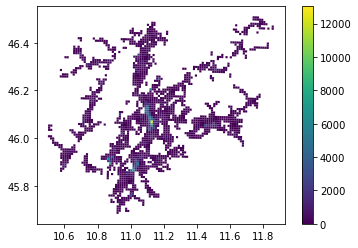

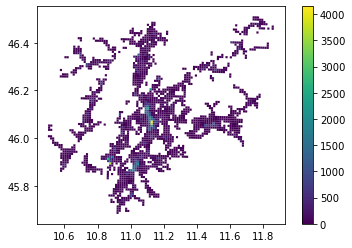

In [30]:
#così per vedere cosa esce faccio il plot del lunedi della prima settimana di novembre

(list_merge_cg_day[1][list_merge_cg_day[1]['weekday']==1]).plot('consumo_ps', legend=True) #eskere

(list_merge_cg_night[1][list_merge_cg_night[1]['weekday']==1]).plot('consumo_ps', legend=True) 

#si vede che nella legenda i consumi per la notte sono molto minori 

Voglio associare ad ogni consumo_ps un grado: alto (A), medio (M), basso (B).

Per fare ciò devo tenere conto che ogni settimana ha un consumo diverso e mi aspetto variazioni principalmente tra i due mesi di novembre e dicembre. 
Mi pare ragionevole decidere di assegnare i valori A,M,B osservando il valore minimo e il valore massimo del consumo_ps su ognuna delle 8 settimane e calcolare il valore medio del consumo_ps (sempre per ognuna delle settimane). 

Devo tenere conto anche della divisione in fasce orarie. Honestly credo che la cosa migliore sia affidare dei valori A,M,B in base ad una valutazione di tutti i dati.

Farò una valutazione abbastanza spannometrica poi vedremo se cambiarla.

In [31]:
#max consumi si avranno di giorno
max_consumo = []
for i in range(8):
    s=list_merge_cg_day[i]['consumo_ps']    
    max_consumo.insert(i, max(s))
    
#min consumi si avranno di notte
min_consumo = []
for i in range(8):
    s=list_merge_cg_night[i]['consumo_ps']    
    min_consumo.insert(i, min(s))

In [32]:
max_consumo #sono 8 valori che rappresentano il consumo massimo per ogni settimana 

[13298.812032627084,
 13800.429001526822,
 14357.831573951693,
 14607.157842486202,
 15349.219842294775,
 15015.252177768927,
 15911.182159110962,
 14229.991821091855]

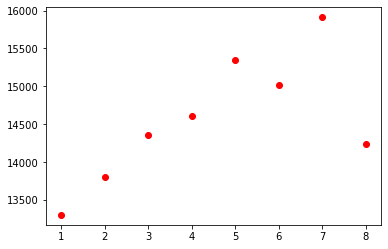

In [33]:
plt.plot([1,2,3,4,5,6,7,8], max_consumo, 'ro')

#come si vede dal plot il valore max del consumo cresce costantemente ma poi si sblenfa un po' verso la fine: 
#ao frate che sta succedendo?! 

#ultima settimana (8) include natale: immagino ci siano un tot di strutture lavorative e zone industriali chiuse
#non mi spiego la settimana 6 honestly: tony spero tu abbia qualche idea

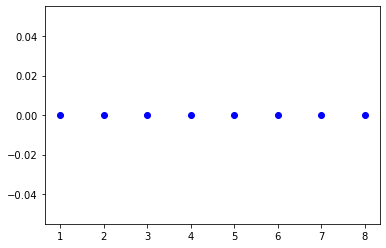

In [34]:
plt.plot([1,2,3,4,5,6,7,8], min_consumo, 'bo')
#consumo min è sempre 0 

In [35]:
#per fare una media del consumo giornaliero faccio somma delle medie giornaliera e notturna 

media_consumo = []
for i in range(8):
    sd=list_merge_cg_day[i]['consumo_ps']
    sn=list_merge_cg_night[i]['consumo_ps']
    media_consumo.insert(i, statistics.mean(sd)+statistics.mean(sn))
media_consumo

[346.65236966794356,
 350.26159018477824,
 376.01689946774195,
 429.267846774496,
 385.8470330870968,
 398.14919673850807,
 402.1679178534274,
 325.9561973488911]

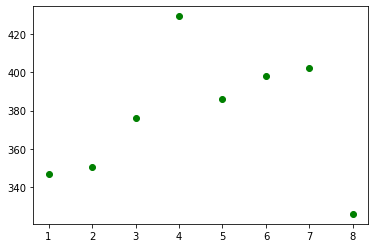

In [36]:
plt.plot([1,2,3,4,5,6,7,8], media_consumo, 'go') 
#boh non so bene spiegarmi sto graficaccio --> sopratutto quel picco nella quarta settimana di novembre: NO SENSE

In [37]:
#a sto punto mi sa che per quanto riguarda il valor medio farò media tra valor max e min
mean_consumo = np.divide(max_consumo, 2*np.ones(8))
mean_consumo

array([6649.40601631, 6900.21450076, 7178.91578698, 7303.57892124,
       7674.60992115, 7507.62608888, 7955.59107956, 7114.99591055])

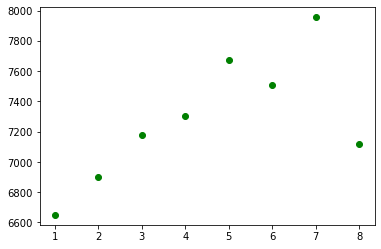

In [38]:
plt.plot([1,2,3,4,5,6,7,8], mean_consumo, 'go') 

Per capire meglio come sono distribuiti i consumi faccio un grafichello

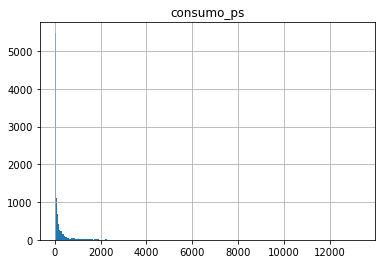

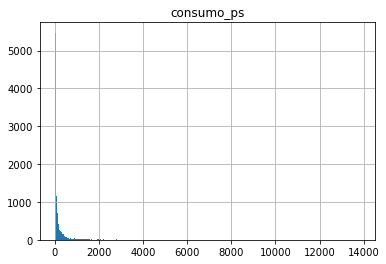

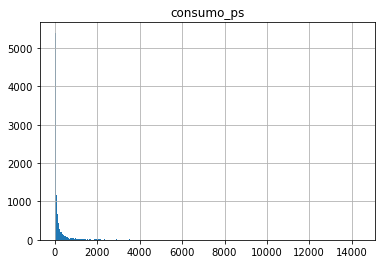

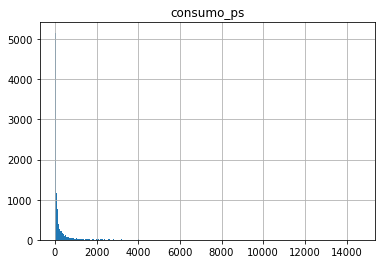

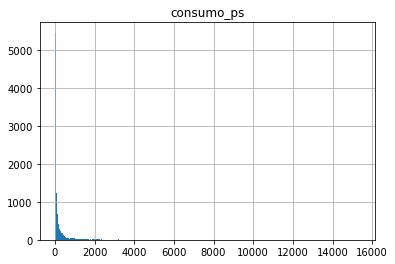

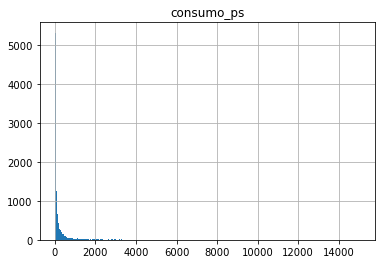

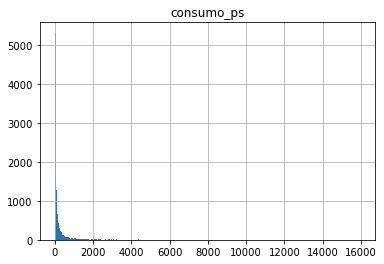

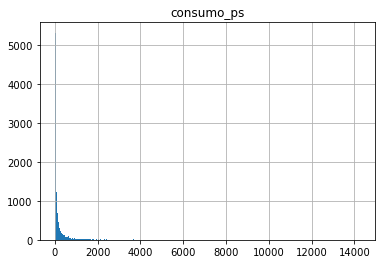

In [39]:
#qua lo faccio per la fascia oraria giornaliera 

for i in range(8):
    list_merge_cg_day[i].hist(column='consumo_ps', bins=300) 
    
#quello che si vede è che la maggior parte dei consumi_ps sta nella fascia minore 
#sono poche le squareid che hanno consumi elevati 

In [40]:
list_merge_cg_day[i]

,cellId,weekday,timestamp,day,consumo_ps,geometry
0,155,0.0,1.387753e+09,2013-12-23,8.807304,"POLYGON ((10.91493 45.69100, 10.92777 45.69079..."
1,155,1.0,1.387840e+09,2013-12-24,7.497739,"POLYGON ((10.91493 45.69100, 10.92777 45.69079..."
2,155,2.0,1.387926e+09,2013-12-25,7.900522,"POLYGON ((10.91493 45.69100, 10.92777 45.69079..."
3,155,3.0,1.388012e+09,2013-12-26,7.574956,"POLYGON ((10.91493 45.69100, 10.92777 45.69079..."
4,155,4.0,1.388099e+09,2013-12-27,6.534261,"POLYGON ((10.91493 45.69100, 10.92777 45.69079..."
...,...,...,...,...,...,...
9915,11099,0.0,1.387753e+09,2013-12-23,27.024605,"POLYGON ((11.76477 46.51064, 11.77778 46.51033..."
9916,11099,1.0,1.387840e+09,2013-12-24,27.541253,"POLYGON ((11.76477 46.51064, 11.77778 46.51033..."
9917,11099,2.0,1.387926e+09,2013-12-25,27.731546,"POLYGON ((11.76477 46.51064, 11.77778 46.51033..."
9918,11099,3.0,1.388012e+09,2013-12-26,21.719018,"POLYGON ((11.76477 46.51064, 11.77778 46.51033..."


In [41]:
#faccio la media dei consumi massimi
media_max_cons = np.mean(max_consumo)
media_max_cons

14571.234556357289

In [42]:
#faccio la media dei consumi medi
media_mean_cons = np.mean(mean_consumo)
media_mean_cons

7285.6172781786445

In [43]:
#stabilisco questi come estremi della mia divisione dei consumi, che vedrà la fascia B andare da 0 a i1, la 
#fascia M da i1 a i2 e la fascia A da i2 a max(max_consumo)

#i1 = ( max(max_consumo)-np.mean(mean_consumo) )/2 
#i2 = np.mean(mean_consumo) + i1

i1 = 300
i2 = 7285 + 300

In [44]:
#un po randomicamente divido le zone 

In [45]:
#vabbe insomma, ho pensato alle seguenti suddivisioni per A, M, B ma possiamo tranquillamente modificarle. 
#per ora le ho messe un po random (vedi cella sopra) (sono anche abbastanza a discrezione di chi fa questa analisi)

#PER IL GIORNO !!

mask_B_day = [(d['consumo_ps'] >= 0) & (d['consumo_ps'] <= i1) for d in list_merge_cg_day]

list_merge_cg_B_day=[]
for i in range(8):
    d = list_merge_cg_day[i]
    list_merge_cg_B_day.insert(i,d.loc[mask_B_day[i]])
    
#list_merge_cg_B_day contiene 8 dfs che corrispondono alle 8 settimane --> a ogni settimana ho applicato col ciclo for 
#la maschera mask_B che seleziona i valori che soddisfano la condizione di essere nella zona B a basso consumo

#ripeto il procedimento per zona M e zona A

mask_M_day = [(d['consumo_ps'] > i1) & (d['consumo_ps'] <= i2) for d in list_merge_cg_day]

list_merge_cg_M_day=[]
for i in range(8):
    d = list_merge_cg_day[i]
    list_merge_cg_M_day.insert(i,d.loc[mask_M_day[i]])
    
    
mask_A_day = [(d['consumo_ps'] > i2) & (d['consumo_ps'] <= max(max_consumo)) for d in list_merge_cg_day]

list_merge_cg_A_day=[]
for i in range(8):
    d = list_merge_cg_day[i]
    list_merge_cg_A_day.insert(i,d.loc[mask_A_day[i]])
    
    
#PER LA NOTTE !!

mask_B_night = [(d['consumo_ps'] >= 0) & (d['consumo_ps'] <= i1) for d in list_merge_cg_night]

list_merge_cg_B_night=[]
for i in range(8):
    d = list_merge_cg_night[i]
    list_merge_cg_B_night.insert(i,d.loc[mask_B_night[i]])
    
#list_merge_cg_B_day contiene 8 dfs che corrispondono alle 8 settimane --> a ogni settimana ho applicato col ciclo for 
#la maschera mask_B che seleziona i valori che soddisfano la condizione di essere nella zona B a basso consumo

#ripeto il procedimento per zona M e zona A

mask_M_night = [(d['consumo_ps'] > i1) & (d['consumo_ps'] <= i2) for d in list_merge_cg_night]

list_merge_cg_M_night=[]
for i in range(8):
    d = list_merge_cg_night[i]
    list_merge_cg_M_night.insert(i,d.loc[mask_M_night[i]])
    
    
mask_A_night = [(d['consumo_ps'] > i2) & (d['consumo_ps'] <= max(max_consumo)) for d in list_merge_cg_night]

list_merge_cg_A_night=[]
for i in range(8):
    d = list_merge_cg_night[i]
    list_merge_cg_A_night.insert(i,d.loc[mask_A_night[i]])

In [46]:
#ora aggiungo una colonna ad ognuno dei dfs di ognuna delle 3 liste che mi suddividono i dfs in A,M,B consumo e poi
#riunisco tra di loro le tre liste. Così riottengo la lista di partenza, con l'aggiunta di una colonna che mi 
#identifica se il consumo è A,M,B

#Assegno B=1,M=2,A=3

list_merge_cg_B_day = [d.assign(index_cons=np.ones(len(d))) for d in list_merge_cg_B_day]
list_merge_cg_M_day = [d.assign(index_cons=2*np.ones(len(d))) for d in list_merge_cg_M_day]
list_merge_cg_A_day = [d.assign(index_cons=3*np.ones(len(d))) for d in list_merge_cg_A_day]

list_merge_cg_B_night = [d.assign(index_cons=np.ones(len(d))) for d in list_merge_cg_B_night]
list_merge_cg_M_night = [d.assign(index_cons=2*np.ones(len(d))) for d in list_merge_cg_M_night]
list_merge_cg_A_night = [d.assign(index_cons=3*np.ones(len(d))) for d in list_merge_cg_A_night]


#riunisco tutta la situa (sto impazzendo credo)
#voglio riunire il primo di ogni lista con il primo delle altre liste

list_merge_cg_BM_day =[] 
for i in range(8):
    b = list_merge_cg_B_day[i]
    m = list_merge_cg_M_day[i]
    list_merge_cg_BM_day.insert(i, pd.concat([b, m], ignore_index=True))

list_merge_cg_day = []
for i in range(8):
    bm = list_merge_cg_BM_day[i]
    a = list_merge_cg_A_day[i]
    list_merge_cg_day.insert(i, pd.concat([bm, a], ignore_index=True))

    
    
list_merge_cg_BM_night =[] 
for i in range(8):
    b = list_merge_cg_B_night[i]
    m = list_merge_cg_M_night[i]
    list_merge_cg_BM_night.insert(i, pd.concat([b, m], ignore_index=True))

list_merge_cg_night = []
for i in range(8):
    bm = list_merge_cg_BM_night[i]
    a = list_merge_cg_A_night[i]
    list_merge_cg_night.insert(i, pd.concat([bm, a], ignore_index=True))



In [47]:
#salvo lista di dfs così posso usara poi in altri script

#with open("dflist_consumi", "wb") as fp:
    #pickle.dump(dflist_consumi, fp)

# Dataset province e comuni

In [48]:
df_province=gpd.read_file(data_path / files['province'])
df_comuni=gpd.read_file(data_path / files['comuni'])

In [49]:
#Seleziono le province del trentino alto adige ---> TN e BZ

province_taa= df_province.loc[df_province['COD_REG']==4]
province_taa

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_UTS,DEN_PROV,DEN_CM,DEN_UTS,SIGLA,TIPO_UTS,Shape_Leng,Shape_Area,geometry
20,2,4,21,0,21,Bolzano,-,Bolzano,BZ,Provincia autonoma,619412.600013,7.399378e+09,"POLYGON ((765951.93020 5175460.26110, 765957.2..."
21,2,4,22,0,22,Trento,-,Trento,TN,Provincia autonoma,594758.785501,6.208170e+09,"POLYGON ((707907.40110 5095782.14820, 708332.7..."


<AxesSubplot:>

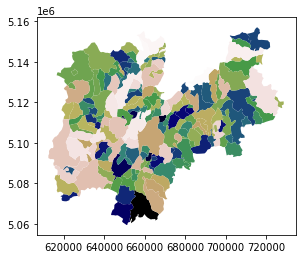

In [50]:
#codice provincia di trento è 22
#seleziono comuni che fanno parte della provincia di trento

comuni_t = df_comuni.loc[df_comuni['COD_PROV']==22]
comuni_t.plot('PRO_COM',aspect=1,cmap='gist_earth')

In [51]:
#droppo alcune colonne che sono inutili
df_comuni=comuni_t.drop(['COD_RIP', 'COD_REG', 'COD_PROV', 'COD_UTS', 'PRO_COM', 'PRO_COM_T', 'COMUNE_A', 'CC_UTS'], axis=1)

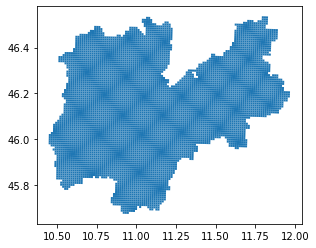

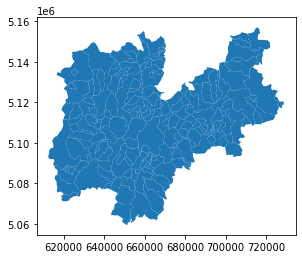

In [52]:
ax1 = df_grid.plot()
ax2 = df_comuni.plot(aspect=1)

In [53]:
#c'è un problema cioè: le scale dei due plot sono diverse
#devo dunque riscalare gli assi per il plot dei comuni 

In [54]:
#piglio gli estremi max e min su assi x e y dei due plot

miny1=ax1.get_ylim()[0]
maxy1=ax1.get_ylim()[1]

minx1=ax1.get_xlim()[0]
maxx1=ax1.get_xlim()[1]

miny2=ax2.get_ylim()[0]
maxy2=ax2.get_ylim()[1]

minx2=ax2.get_xlim()[0]
maxx2=ax2.get_xlim()[1]

In [55]:
#scrivo le trasformazioni per riscalare gli assi del plot dei comuni

xscale = (maxx1-minx1)/(maxx2-minx2)
yscale = (maxy1-miny1)/(maxy2-miny2)

xshift = (minx1*maxx2-maxx1*minx2)/(maxx2-minx2)
yshift = (miny1*maxy2-maxy1*miny2)/(maxy2-miny2)

<AxesSubplot:>

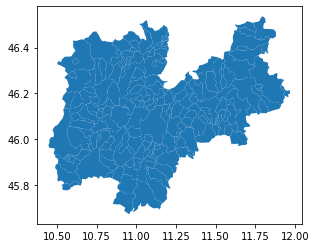

In [56]:
t = df_comuni.scale(xscale, yscale, origin=(xshift, yshift))
df_comuni_rescaled = df_comuni.drop('geometry', axis=1)
df_comuni_rescaled['geometry'] = t
df_comuni_rescaled = df_comuni_rescaled.reset_index()
df_comuni_rescaled = df_comuni_rescaled.drop('index', axis=1)
df_comuni_rescaled.plot()

#ecco qua il df contenente info sui comuni ma con le proporzioni geometriche corrette 

Sarebbe ora molto utile legare df_grid ai comuni, in modo da identificare quali SQUAREID compongono quale comune

# unisco df comuni a df grid

In [57]:
#per fare ciò useremo treegeometry.sindex.nearest(geometry) che associa ad ogni geometry in geometry la treegeometry
#più vicina

In [58]:
df_comuni_rescaled

,COD_CM,COMUNE,Shape_Leng,Shape_Area,geometry
0,0,Ala,65506.379401,1.200270e+08,"POLYGON ((11.00982 45.82488, 11.00002 45.82284..."
1,0,Albiano,12737.587681,9.804277e+06,"POLYGON ((11.20973 46.15139, 11.20723 46.15298..."
2,0,Aldeno,14067.700841,9.035749e+06,"POLYGON ((11.11551 45.98023, 11.11809 45.98278..."
3,0,Andalo,21864.110687,1.141823e+07,"MULTIPOLYGON (((10.95035 46.12970, 10.95034 46..."
4,0,Arco,47193.746836,6.340274e+07,"POLYGON ((10.93667 45.96460, 10.93404 45.96016..."
...,...,...,...,...,...
161,0,San Giovanni di Fassa,60680.110938,9.994989e+07,"POLYGON ((11.63430 46.47400, 11.63274 46.47605..."
162,0,Terre d'Adige,29673.296854,1.651813e+07,"MULTIPOLYGON (((11.03502 46.13567, 11.03521 46..."
163,0,Borgo d'Anaunia,55292.603123,6.356419e+07,"MULTIPOLYGON (((11.20505 46.43635, 11.20368 46..."
164,0,Novella,41468.087283,4.644838e+07,"POLYGON ((11.09999 46.41483, 11.09865 46.41660..."


In [59]:
#usiamo polygon dei comuni come tree geometry e polygon che identificano le squareid come input geometry
#mi baso sull'idea che il comune più vicino alla cella sia quello che contiene la cella. spero sia vero ciao

import rtree
from rtree import index
idx = index.Index()

In [60]:
poly_com = gpd.GeoSeries(df_comuni_rescaled['geometry'][0:len(df_comuni_rescaled)])
poly_grid = gpd.GeoSeries(df_grid['geometry'])

a = poly_com.sindex.nearest(geometry=poly_grid, return_all=False)

In [61]:
df_grid_index = df_grid.assign(index_grid=a[0]) #associo a ogni quareid un indice
df_grid_index = df_grid.assign(index_com = a[1]) #associo a ogni squareid l'indice del comune in cui si trova

df_comuni_rescaled_index = df_comuni_rescaled.assign(index_com = np.array(range(len(df_comuni_rescaled)))) 

In [62]:
#ora voglio unire i dfs. In particolare voglio che ad ogni squareid di df_grid venga associato il comune in cui si trova

df_merged_cg = df_grid_index.merge(df_comuni_rescaled_index.drop(['geometry', 'COD_CM', 'Shape_Leng', 'Shape_Area'], axis=1), how='left', on='index_com')

In [63]:
df_merged_cg

#questo df associa ad ogni squareid un comune

,cellId,geometry,index_com,COMUNE
0,38,"POLYGON ((10.91462 45.68201, 10.92746 45.68179...",5,Avio
1,39,"POLYGON ((10.92746 45.68179, 10.94029 45.68157...",5,Avio
2,40,"POLYGON ((10.94029 45.68157, 10.95312 45.68136...",5,Avio
3,154,"POLYGON ((10.90209 45.69122, 10.91493 45.69100...",5,Avio
4,155,"POLYGON ((10.91493 45.69100, 10.92777 45.69079...",5,Avio
...,...,...,...,...
6570,11336,"POLYGON ((11.80475 46.52767, 11.81777 46.52735...",24,Canazei
6571,11337,"POLYGON ((11.81777 46.52735, 11.83080 46.52703...",24,Canazei
6572,11452,"POLYGON ((11.79219 46.53698, 11.80521 46.53666...",24,Canazei
6573,11453,"POLYGON ((11.80521 46.53666, 11.81824 46.53634...",24,Canazei


<AxesSubplot:>

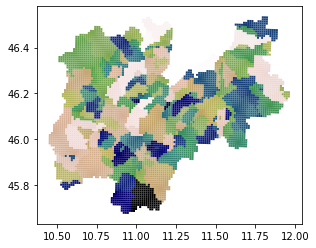

In [64]:
df_merged_cg.plot('index_com', cmap='gist_earth')

# Dati twitter

In [65]:
with open(data_path / files['twitter']) as f:
    tweets_json = json.load(f)

tweets = gpd.GeoDataFrame(tweets_json['features'])

In [66]:
tweets['geometry'] = tweets['geomPoint.geom'].apply(lambda x:Point(x['coordinates'][0], x['coordinates'][1]))
tweets.drop(columns=['geomPoint.geom', 'user', 'municipality.name', 'municipality.acheneID', 'language', 'entities'],inplace=True)

In [67]:
#splitto colonna giorno e ora in due colonne
#questa cosa mi torna utile perchè voglio avere un riferimento temporale da poter usare come chiave per
#confrontare questo df con il df dei consumi, in cui il tempo l'ho convertito in 'timestamp' usando solo il giorno
#e non l'ora --> ora faccio la stessa cosa qui 

tweets.drop('timestamp', axis=1) #droppo timestamp "preimpostato" perchè si basa su data+ora e me ne faccio nulla scritto così
tweets[['day', 'time']] = tweets['created'].str.split('T', 1, expand=True) 

#ora creo nuovo timestamp che si basi solo sul giorno 

timestamp1 = []
for i in range(len(tweets)):
    s=tweets.day[i]    
    #timestamp.insert(i, time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d").timetuple()) )
    timestamp1.insert(i, parser.parse(tweets.day[i]).timestamp())
    
series_timestamp1 = pd.Series(timestamp1)
tweets = tweets.assign(timestamp=series_timestamp1)

tweets

,created,timestamp,geometry,day,time
0,2013-11-01T00:04:16,1.383260e+09,POINT (11.13000 46.07000),2013-11-01,00:04:16
1,2013-11-01T00:01:14,1.383260e+09,POINT (10.83000 46.23000),2013-11-01,00:01:14
2,2013-11-01T00:43:03,1.383260e+09,POINT (11.46000 46.29000),2013-11-01,00:43:03
3,2013-11-01T00:38:37,1.383260e+09,POINT (11.04000 45.89000),2013-11-01,00:38:37
4,2013-11-01T00:45:40,1.383260e+09,POINT (11.12000 46.20000),2013-11-01,00:45:40
...,...,...,...,...,...
27936,2013-12-31T00:25:48,1.388444e+09,POINT (11.68000 46.42000),2013-12-31,00:25:48
27937,2013-12-29T13:12:46,1.388272e+09,POINT (11.60000 46.31000),2013-12-29,13:12:46
27938,2013-11-19T00:51:39,1.384816e+09,POINT (11.30000 46.11000),2013-11-19,00:51:39
27939,2013-11-23T09:49:36,1.385161e+09,POINT (11.30000 46.11000),2013-11-23,09:49:36


In [68]:
#divido tweets in settimane come avevo fatto per consumi

#per novembre
mask1_n = (tweets['day'] >= '2013-11-04') & (tweets['day'] <= '2013-11-08')
tweets_set1_n = tweets.loc[mask1_n]

mask2_n = (tweets['day'] >= '2013-11-11') & (tweets['day'] <= '2013-11-15')
tweets_set2_n = tweets.loc[mask2_n]

mask3_n = (tweets['day'] >= '2013-11-18') & (tweets['day'] <= '2013-11-22')
tweets_set3_n = tweets.loc[mask3_n]

mask4_n = (tweets['day'] >= '2013-11-25') & (tweets['day'] <= '2013-11-29')
tweets_set4_n = tweets.loc[mask4_n]

#per dicembre
mask1_d = (tweets['day'] >= '2013-12-02') & (tweets['day'] <= '2013-12-06')
tweets_set1_d = tweets.loc[mask1_d]

mask2_d = (tweets['day'] >= '2013-12-09') & (tweets['day'] <= '2013-12-13')
tweets_set2_d = tweets.loc[mask2_d]

mask3_d = (tweets['day'] >= '2013-12-16') & (tweets['day'] <= '2013-12-20')
tweets_set3_d = tweets.loc[mask3_d]

mask4_d = (tweets['day'] >= '2013-12-23') & (tweets['day'] <= '2013-12-27')
tweets_set4_d = tweets.loc[mask4_d]

In [69]:
#divido in fasce orarie

#novembre
mask1_nday = (tweets_set1_n['time'] >= lld) & (tweets_set1_n['time'] < uld)
tweets_set1_nday = tweets_set1_n.loc[mask1_nday]
mask1_nnight = (tweets_set1_n['time'] >= lln) & (tweets_set1_n['time'] <= uln)
tweets_set1_nnight = tweets_set1_n.loc[mask1_nnight]

mask2_nday = (tweets_set2_n['time'] >= lld) & (tweets_set2_n['time'] < uld)
tweets_set2_nday = tweets_set2_n.loc[mask2_nday]
mask2_nnight = (tweets_set2_n['time'] >= lln) & (tweets_set2_n['time'] <= uln)
tweets_set2_nnight = tweets_set2_n.loc[mask2_nnight]

mask3_nday = (tweets_set3_n['time'] >= lld) & (tweets_set3_n['time'] < uld)
tweets_set3_nday = tweets_set3_n.loc[mask3_nday]
mask3_nnight = (tweets_set3_n['time'] >= lln) & (tweets_set3_n['time'] <= uln)
tweets_set3_nnight = tweets_set3_n.loc[mask3_nnight]

mask4_nday = (tweets_set4_n['time'] >= lld) & (tweets_set4_n['time'] < uld)
tweets_set4_nday = tweets_set4_n.loc[mask4_nday]
mask4_nnight = (tweets_set4_n['time'] >= lln) & (tweets_set4_n['time'] <= uln)
tweets_set4_nnight = tweets_set4_n.loc[mask4_nnight]

#dicembre 
mask1_dday = (tweets_set1_d['time'] >= lld) & (tweets_set1_d['time'] < uld)
tweets_set1_dday = tweets_set1_d.loc[mask1_dday]
mask1_dnight = (tweets_set1_d['time'] >= lln) & (tweets_set1_d['time'] <= uln)
tweets_set1_dnight = tweets_set1_d.loc[mask1_dnight]

mask2_dday = (tweets_set2_d['time'] >= lld) & (tweets_set2_d['time'] < uld)
tweets_set2_dday = tweets_set2_d.loc[mask2_dday]
mask2_dnight = (tweets_set2_d['time'] >= lln) & (tweets_set2_d['time'] <= uln)
tweets_set2_dnight = tweets_set2_d.loc[mask2_dnight]

mask3_dday = (tweets_set3_d['time'] >= lld) & (tweets_set3_d['time'] < uld)
tweets_set3_dday = tweets_set3_d.loc[mask3_dday]
mask3_dnight = (tweets_set3_d['time'] >= lln) & (tweets_set3_d['time'] <= uln)
tweets_set3_dnight = tweets_set3_d.loc[mask3_dnight]

mask4_dday = (tweets_set4_d['time'] >= lld) & (tweets_set4_d['time'] < uld)
tweets_set4_dday = tweets_set4_d.loc[mask4_dday]
mask4_dnight = (tweets_set4_d['time'] >= lln) & (tweets_set4_d['time'] <= uln)
tweets_set4_dnight = tweets_set4_d.loc[mask4_dnight]

In [70]:
#unisco dfs divisi per settimane in una lista come avevo già fatto per i consumi 

df_tweets_list_day = [tweets_set1_nday, tweets_set2_nday, tweets_set3_nday, tweets_set4_nday, tweets_set1_dday, tweets_set2_dday, tweets_set3_dday, tweets_set4_dday]

df_tweets_list_night = [tweets_set1_nnight, tweets_set2_nnight, tweets_set3_nnight, tweets_set4_nnight, tweets_set1_dnight, tweets_set2_dnight, tweets_set3_dnight, tweets_set4_dnight]



In [71]:
#metto indicatore della giornata da lunedi a venerdi (da 0 a 4) e droppo colonna created

df_tweets_list1_day = [(df.assign(weekday=df.apply(lambda r: parser.parse(r['created']).weekday(), axis=1))).drop('created', axis=1) for df in df_tweets_list_day]

df_tweets_list1_night = [(df.assign(weekday=df.apply(lambda r: parser.parse(r['created']).weekday(), axis=1))).drop('created', axis=1) for df in df_tweets_list_night]


In [72]:
df_tweets_list1_day = [d.reset_index().drop('index', axis=1) for d in df_tweets_list1_day]

df_tweets_list1_night = [d.reset_index().drop('index', axis=1) for d in df_tweets_list1_night]

Tweets sensatamente non hanno sta gran correlazione con i consumi. Proviamo comunque ad usarli e vediamo come va.

Ogni tweet rilevato è associato ad un punto sulla mappa. Ognuno di questi punti è contenuto in uno squareid del df_grid. Visto che abbiamo legato i consumi agli squareid, conviene anche in questo caso legare i tweet agli squareid.

Usiamo nuovamente rtree per trovare il polygon relativo ad uno squareid più vicino ad ogni tweet (questo polygon sarà sensatamente quello che contiene il punto che indica il tweet).
Associo quindi ogni tweet ad uno squareid e poi sommo su tutti gli squareid per trovare numero tot di tweets per squareid.

(rispetto alle altre volte che ho usato questo metodo la difficoltà qua sta nel fatto che devo farlo per ogni dfs contenuto in df_tweets_list, che è un array di dfs. infatti ho diviso i miei dati per settimane)

In [73]:
import rtree
from rtree import index
idx = index.Index()

#punti (tweets) da usare come input geometry

listpoly_day = [gpd.GeoSeries(d['geometry']) for d in df_tweets_list1_day]
listpoly_night = [gpd.GeoSeries(d['geometry']) for d in df_tweets_list1_night]
#credo siano uguali queste due liste, ciò che cambia dovrebbe essere solo il valore del consumo. cmq per sicurezza 
#mantengo separati i due procedimenti per giorno e notte


#treegeometry è invece df_grid

listpoints = gpd.GeoSeries(df_grid['geometry'])


list_a_day = [listpoints.sindex.nearest(geometry=p, return_all=False) for p in listpoly_day]
list_a_night = [listpoints.sindex.nearest(geometry=p, return_all=False) for p in listpoly_night]


In [74]:
#faccio procedimento per assegnare ad ogni riga del df meteo le grid corrispondenti alla data stazione meteo (cioè
#le squareid che quel meteo riguarda)

df_tweets_list2_day = []
for i in range(8):
    d = df_tweets_list1_day[i]
    d = d.assign(index_grid=list_a_day[i][1])
    df_tweets_list2_day.insert(i, d)

df_tweets_list2_night = []
for i in range(8):
    d = df_tweets_list1_night[i]
    d = d.assign(index_grid=list_a_night[i][1])
    df_tweets_list2_night.insert(i, d)

In [75]:
#ora unisco a df_tweets_list2 il df_grid
# prima associo a df_grid una colonna con index_grid

df_grid_index = df_grid.assign(index_grid = np.array(range(len(df_grid))))

In [76]:
#associo ad ogni df in df_tweets_list2 gli squareid che corrispondono al luogo in cui è situato il tweet
#ottengo una lista contenente le 8 settimane mergiate con df_grid. La geometry associata è quella degli squareid

list_merged_tg_day = [df_grid_index.merge(d.drop('geometry',axis=1), how='right', on='index_grid') for d in df_tweets_list2_day]
list_merged_tg_night = [df_grid_index.merge(d.drop('geometry',axis=1), how='right', on='index_grid') for d in df_tweets_list2_night]


<AxesSubplot:>

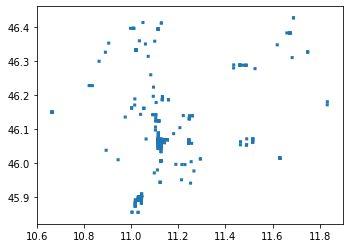

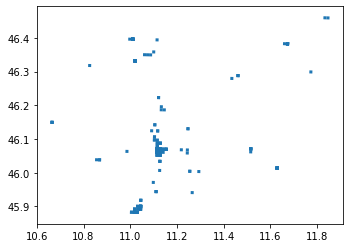

In [77]:
list_merged_tg_day[1].plot() #ora i tweets non sono piu punti ma ogni tweet è identificato da uno square del df_grid 
list_merged_tg_night[1].plot()

#si vede che cambia un po la distribuzione dei tweet da giorno a notte

In [78]:
#ora sommo sugli squareid per ottenere numero tot di tweets per squareid

#prima di tutto aggiungo una colonna a list_merged_tg con degli uni (1) che stanno a significare che ogni riga 
#corrisponde ad UN tweet
list_single_tweet_day = [d.assign(num_tweets = 1) for d in list_merged_tg_day]
list_single_tweet_night = [d.assign(num_tweets = 1) for d in list_merged_tg_night]

#dopodichè sommo sulle cellId uguali (tenendo conto dei giorni diversi) per ottenere tweet totali per cellId
list_grouped_tg_day = [d.groupby(['cellId','day', 'weekday','index_grid','timestamp']).sum('num_tweets').reset_index() for d in list_single_tweet_day]
list_grouped_tg_night = [d.groupby(['cellId','day', 'weekday','index_grid','timestamp']).sum('num_tweets').reset_index() for d in list_single_tweet_night]


#devo riassociare la geometry perchè usando groupby l'ho perduta
list_grouped_tg_day = [df_grid.merge(d, how='right', on='cellId') for d in list_grouped_tg_day]
list_grouped_tg_night = [df_grid.merge(d, how='right', on='cellId') for d in list_grouped_tg_night]


<AxesSubplot:>

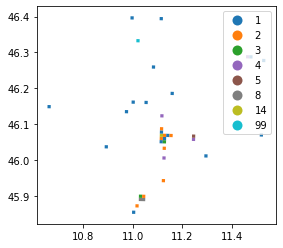

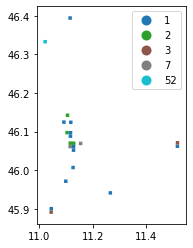

In [79]:
#provo a plottare i tweet del lunedi della seconda settimana (di novembre) 
#plotto squareid contenenti dei tweet e li coloro in base a quanti tweets contengono

list_grouped_tg_day[1][list_grouped_tg_day[1]['weekday']==0].plot('num_tweets', legend=True, categorical=True)
list_grouped_tg_night[1][list_grouped_tg_night[1]['weekday']==0].plot('num_tweets', legend=True, categorical=True)

#nella legenda ci sono il numero di tweets presenti in una certa cellId

<AxesSubplot:>

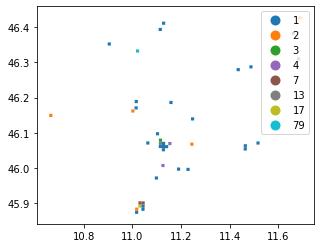

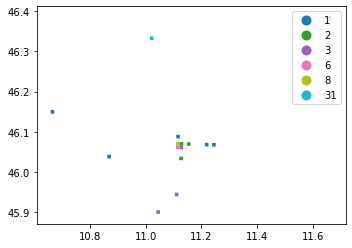

In [80]:
# per il martedì della prima sett di nov 
list_grouped_tg_day[1][list_grouped_tg_day[1]['weekday']==1].plot('num_tweets', legend=True, categorical=True)
list_grouped_tg_night[1][list_grouped_tg_night[1]['weekday']==1].plot('num_tweets', legend=True, categorical=True)

# Dati meteo

questo dataframe contiene le rilevazioni meteo ogni 15 min (se non sbaglio) disposti male, è un cesso usaro cosi. 
percui qua droppiamo un tot di colonne brutte e teniamo un df più maneggiabile. Onestamente non me la sento di affrontare giornate di bestemmie per sistemare l'obrobrio iniziale rappresentato da questo df e percui mi accontento più che felicemente di usare quello semplificato. ne df che usiamo noi dunque non c'è la divisione per orari diversi, ma solo per giornate, con informazioni basilari tipo min e max temperatura di quella gironata ecc.

In [81]:
with open(data_path / files['weather']) as f:
    weather_json = json.load(f)

weather = gpd.GeoDataFrame(weather_json['features'])

In [82]:
#droppo colonne inutili

column_todrop=weather.columns[8:298]
weather=weather.drop(columns=list(column_todrop))

#sistemo la geometry

weather['geometry'] = weather['geomPoint.geom'].apply(lambda x:Point(x['coordinates'][0], x['coordinates'][1]))
weather.drop(columns=['geomPoint.geom'],inplace=True)

#passo true/false nella colonna 'precipitation' in int

weather['precipitation'] = weather['precipitation'].astype(int)

weather

,station,elevation,date,timestamp,minTemperature,maxTemperature,precipitation,geometry
0,T0071,905,2013-11-01,1383260400,4.5,12.3,0,POINT (10.79583 46.31340)
1,T0032,1155,2013-11-01,1383260400,6.5,10.2,0,POINT (11.25372 45.94027)
2,T0096,1205,2013-11-01,1383260400,6.5,11.8,0,POINT (11.66458 46.38364)
3,T0074,720,2013-11-01,1383260400,6.2,13.6,0,POINT (10.91841 46.35160)
4,T0101,201,2013-11-01,1383260400,11.1,16.3,0,POINT (11.07973 46.15635)
...,...,...,...,...,...,...,...,...
2190,T0431,1055,2013-12-31,1388444400,-5.5,0.5,0,POINT (11.33626 46.26304)
2191,T0428,525,2013-12-31,1388444400,-2.2,6.9,0,POINT (10.64241 45.94062)
2192,T0437,1465,2013-12-31,1388444400,-9.9,-2.4,0,POINT (11.76685 46.47832)
2193,T0469,801,2013-12-31,1388444400,-4.1,2.7,0,POINT (11.62991 46.05718)


In [83]:
#cercando sulla descrizione dei datasets ho trovato che le stazioni meteo sono 36
#individuo quindi le 36 stazioni meteo

weather_stations = weather.groupby('station').sum().reset_index()['station'].to_frame()

#e associo un indice ad ogni stazione
weather_stations = weather_stations.assign(index_wstation=np.array(range(36)))

In [84]:
#unisco a dataframe weather  una colonna con indici che identificano le stazioni

weather = weather.merge(weather_stations, how='left',right_on = 'station', left_on ='station')
weather

,station,elevation,date,timestamp,minTemperature,maxTemperature,precipitation,geometry,index_wstation
0,T0071,905,2013-11-01,1383260400,4.5,12.3,0,POINT (10.79583 46.31340),1
1,T0032,1155,2013-11-01,1383260400,6.5,10.2,0,POINT (11.25372 45.94027),0
2,T0096,1205,2013-11-01,1383260400,6.5,11.8,0,POINT (11.66458 46.38364),3
3,T0074,720,2013-11-01,1383260400,6.2,13.6,0,POINT (10.91841 46.35160),2
4,T0101,201,2013-11-01,1383260400,11.1,16.3,0,POINT (11.07973 46.15635),4
...,...,...,...,...,...,...,...,...,...
2190,T0431,1055,2013-12-31,1388444400,-5.5,0.5,0,POINT (11.33626 46.26304),32
2191,T0428,525,2013-12-31,1388444400,-2.2,6.9,0,POINT (10.64241 45.94062),31
2192,T0437,1465,2013-12-31,1388444400,-9.9,-2.4,0,POINT (11.76685 46.47832),33
2193,T0469,801,2013-12-31,1388444400,-4.1,2.7,0,POINT (11.62991 46.05718),35


<AxesSubplot:>

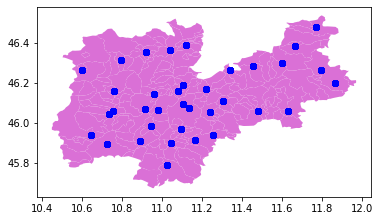

In [85]:
#plotto stazioni meteo sulla mappa dei comuni 

ax = df_comuni_rescaled.plot(color='orchid')

divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="7%", pad=0.1)
#size è la larghezza, pad è la distanza 

weather.plot(ax=ax, color='blue')

Visto che alla fine lo scopo è prevedere le celle con maggiori consumi, dobbiamo associare ad ogni cella una stazione meteo.  

Quello che facciamo ora è associare una stazione meteo ad ogni comune del dataframe df_comuni_rescaled

In [86]:
#usiamo rtree per trovare le stazioni (punti che identificano le stazioni = tree geometry) più vicine ai 
#comuni (poligoni che identificano i comuni = input geometry)

import rtree
from rtree import index
idx = index.Index()

In [87]:
#array di poligoni da usare come input geometry

poly = gpd.GeoSeries(df_comuni_rescaled['geometry'][0:len(df_comuni_rescaled)])

In [88]:
#uso le le 36 geometry delle 36 stazioni meteo come array di punti = tree geometry
#per farlo selezioni le geometry delle 36 stazioni meteo dal df weather

points = gpd.GeoSeries(weather.drop_duplicates(subset='index_wstation').reset_index()['geometry'])

In [89]:
#troviamo ora un array di due array a=[b,c]
#b contiene l'indice che identifica la input geometry (poly = comuni)
#c contiene l'indice che identifica la tree geometry (points = stazioni meteo)

a = points.sindex.nearest(geometry=poly, return_all=False)

#return_all=False è servito perchè con questo metodo a un comune possono essere associate più di una stazione meteo
#con return_all=False viene scelta una sola stazione meteo per ogni comune

In [90]:
#nel df dei comuni aggiungo una colonna con index_com (indice identificativo del comune) e una
#con index_wstation (indice identificativo della stazione meteo più vicina al comune in questione)

df_comuni_rescaled_index = df_comuni_rescaled.assign(index_com = np.array(range(len(df_comuni_rescaled))))
df_comuni_rescaled_index = df_comuni_rescaled_index.assign(index_wstation=a[1])

#gli indici dei comuni index_com assegnati qui sono gli stessi che avevo assegnato creando df_merged_cg

In [91]:
#facciamo merge del df dei comuni con df del meteo
#ad ogni riga del df meteo è associata una stazione. Ad ogni stazione sono associati uno o più comuni --> questa
#informazione è contenuta in df_comuni_rescaled_index, dove per ogni comune è associato un index_wstation che 
#riporta l'indice della stazione meteo associata a tale comune.

#Voglio associare per ogni riga del df weather (identificata dalla sua stazione) le varie righe 
#del df comuni che matchano la stazione di tale riga 

weather1 = weather.drop('geometry', axis=1) #mi interessa mantenere solo la geometry del comune
df_merged_cm = df_comuni_rescaled_index.merge(weather1, how='right', right_on='index_wstation', left_on='index_wstation')
#df_merged_cm=df_merged_cm.drop(['indexpoints', 'COD_CM', 'index'], axis=1)
df_merged_cm

,COD_CM,COMUNE,Shape_Leng,Shape_Area,geometry,index_com,index_wstation,station,elevation,date,timestamp,minTemperature,maxTemperature,precipitation
0,0.0,Caldonazzo,26177.983953,2.148336e+07,"POLYGON ((11.27944 46.00923, 11.27539 46.00951...",19.0,1,T0071,905,2013-11-01,1383260400,4.5,12.3,0
1,0.0,Lavarone,25831.163682,2.634554e+07,"POLYGON ((11.32100 45.96227, 11.31297 45.96141...",60.0,1,T0071,905,2013-11-01,1383260400,4.5,12.3,0
2,0.0,Luserna,21887.300822,8.265319e+06,"POLYGON ((11.36904 45.94659, 11.34207 45.94817...",65.0,1,T0071,905,2013-11-01,1383260400,4.5,12.3,0
3,0.0,Altopiano della Vigolana,31064.325488,4.487673e+07,"POLYGON ((11.19222 46.03040, 11.18901 46.02708...",147.0,1,T0071,905,2013-11-01,1383260400,4.5,12.3,0
4,0.0,Commezzadura,22825.506253,2.191367e+07,"POLYGON ((10.83283 46.33647, 10.82274 46.33690...",42.0,0,T0032,1155,2013-11-01,1383260400,6.5,10.2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10176,0.0,Castello Tesino,78270.402121,1.127751e+08,"POLYGON ((11.62626 46.22032, 11.62240 46.22057...",30.0,34,T0450,1470,2013-12-31,1388444400,-10.2,-0.7,0
10177,0.0,Cinte Tesino,43354.619290,3.073582e+07,"MULTIPOLYGON (((11.63140 46.07244, 11.63097 46...",38.0,34,T0450,1470,2013-12-31,1388444400,-10.2,-0.7,0
10178,0.0,Grigno,30923.987261,4.603053e+07,"POLYGON ((11.64202 46.03464, 11.63938 46.03244...",57.0,34,T0450,1470,2013-12-31,1388444400,-10.2,-0.7,0
10179,0.0,Ospedaletto,17884.495929,1.669921e+07,"POLYGON ((11.59524 46.06400, 11.58949 46.06902...",80.0,34,T0450,1470,2013-12-31,1388444400,-10.2,-0.7,0


<AxesSubplot:>

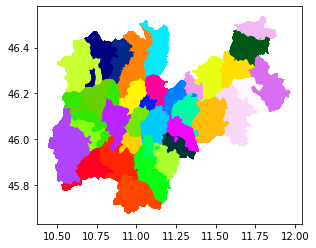

In [92]:
#posso plottare i comuni colorandoli in base all'indice della stazione meteo a loro più vicina

df_merged_cm.plot('index_wstation', cmap='gist_ncar')

#ogni zona colorata rappresenta la zona di azione di una stazione meteo

posso associare ad ogni comune (identificato dal suo index_com) le squareid che lo costituiscono (sfrutto df_merged_cg)

In [93]:
df_merged_cmg = (df_merged_cm.drop(['COD_CM', 'Shape_Leng', 'Shape_Area', 'geometry'],axis=1)).merge(df_merged_cg.drop('COMUNE', axis=1), how='left', on='index_com')
df_merged_cmg

,COMUNE,index_com,index_wstation,station,elevation,date,timestamp,minTemperature,maxTemperature,precipitation,cellId,geometry
0,Caldonazzo,19.0,1,T0071,905,2013-11-01,1383260400,4.5,12.3,0,3923.0,"POLYGON ((11.23444 45.97322, 11.24734 45.97297..."
1,Caldonazzo,19.0,1,T0071,905,2013-11-01,1383260400,4.5,12.3,0,3924.0,"POLYGON ((11.24734 45.97297, 11.26024 45.97272..."
2,Caldonazzo,19.0,1,T0071,905,2013-11-01,1383260400,4.5,12.3,0,3928.0,"POLYGON ((11.29893 45.97194, 11.31183 45.97168..."
3,Caldonazzo,19.0,1,T0071,905,2013-11-01,1383260400,4.5,12.3,0,4041.0,"POLYGON ((11.24770 45.98196, 11.26060 45.98171..."
4,Caldonazzo,19.0,1,T0071,905,2013-11-01,1383260400,4.5,12.3,0,4042.0,"POLYGON ((11.26060 45.98171, 11.27350 45.98145..."
...,...,...,...,...,...,...,...,...,...,...,...,...
401131,Pieve Tesino,89.0,34,T0450,1470,2013-12-31,1388444400,-10.2,-0.7,0,7460.0,"POLYGON ((11.59527 46.23561, 11.60822 46.23532..."
401132,Pieve Tesino,89.0,34,T0450,1470,2013-12-31,1388444400,-10.2,-0.7,0,7461.0,"POLYGON ((11.60822 46.23532, 11.62118 46.23502..."
401133,Pieve Tesino,89.0,34,T0450,1470,2013-12-31,1388444400,-10.2,-0.7,0,7462.0,"POLYGON ((11.62118 46.23502, 11.63414 46.23472..."
401134,Pieve Tesino,89.0,34,T0450,1470,2013-12-31,1388444400,-10.2,-0.7,0,7576.0,"POLYGON ((11.58273 46.24490, 11.59569 46.24460..."


In [94]:
#raggruppo righe del df per squareid (==cellId) e giorni

# df_merged_cmg = ( df_merged_cmg.groupby(['date','cellId','index_com','COMUNE','index_wstation','station','timestamp']).sum() ).reset_index()

#domanda a cui non so rispondere right now: come mai facendo questo groupby perdo un centinaio di righe???
#Mmmmh misterioso. Se faccio groupby aggiungendo anche ('elevation','minTemperature', 'maxTemperature',
#'precipitation') (cioè su tutte le colonne possibili) vedo che ottengo o stesso numero di righe. Mi viene da pensare
#che ci siano delle righe uguali ma boh. --> a questo punto raggruppo anche su (minTemperature', 'maxTemperature',
#'precipitation') perchè non voglio rischiare che altrimenti in queste colonne dei valori si sommino (raddoppiando)
#quando faccio il groupby

df_merged_cmg = ( df_merged_cmg.groupby(['precipitation','minTemperature', 'maxTemperature','date','cellId','index_com','COMUNE','index_wstation','station','timestamp']).sum() ).reset_index()

df_merged_cmg = df_merged_cmg.drop('elevation', axis=1) #tanto fissata una stazione questo è un parametro costante

#unisco ora la geometry relativa ad ogni squareid
df_merged_cmg = df_merged_cmg.merge(df_grid, how='left', on='cellId')

#rinomino colonna date in day
df_merged_cmg.rename(columns = {'date':'day'}, inplace = True)
df_merged_cmg


,precipitation,minTemperature,maxTemperature,day,cellId,index_com,COMUNE,index_wstation,station,timestamp,geometry
0,0,-15.4,-6.7,2013-11-26,6911.0,134.0,Vermiglio,17,T0360,1385420400,"POLYGON ((10.54422 46.21865, 10.55718 46.21847..."
1,0,-15.4,-6.7,2013-11-26,6912.0,134.0,Vermiglio,17,T0360,1385420400,"POLYGON ((10.55718 46.21847, 10.57014 46.21829..."
2,0,-15.4,-6.7,2013-11-26,6913.0,134.0,Vermiglio,17,T0360,1385420400,"POLYGON ((10.57014 46.21829, 10.58310 46.21811..."
3,0,-15.4,-6.7,2013-11-26,6917.0,134.0,Vermiglio,17,T0360,1385420400,"POLYGON ((10.62198 46.21757, 10.63494 46.21738..."
4,0,-15.4,-6.7,2013-11-26,6918.0,134.0,Vermiglio,17,T0360,1385420400,"POLYGON ((10.63494 46.21738, 10.64790 46.21720..."
...,...,...,...,...,...,...,...,...,...,...,...
400948,1,12.2,15.7,2013-11-02,4494.0,54.0,Garniga Terme,10,T0147,1383346800,"POLYGON ((11.05551 46.02159, 11.06842 46.02135..."
400949,1,12.2,15.7,2013-11-02,4495.0,54.0,Garniga Terme,10,T0147,1383346800,"POLYGON ((11.06842 46.02135, 11.08133 46.02112..."
400950,1,12.2,15.7,2013-11-02,4496.0,54.0,Garniga Terme,10,T0147,1383346800,"POLYGON ((11.08133 46.02112, 11.09425 46.02088..."
400951,1,12.2,15.7,2013-11-02,4497.0,54.0,Garniga Terme,10,T0147,1383346800,"POLYGON ((11.09425 46.02088, 11.10716 46.02065..."


# Precipitazioni

In [95]:
df_precip=gpd.read_file(data_path / files['precip'])
df_precip = df_precip.drop('geometry', axis=1)

df_precip_avail=gpd.read_file(data_path / files['precip-avail'])

In [96]:
df_precip 

#field_1 = YYYYMMDDHHmm
#field_2 = id of a given square of Milan/Trentino GRID
#field_3 = intensity: intensity value of the precipitation. It is a value between 0 and 3

,field_1,field_2,field_3
0,201311010000,2383,1
1,201311010020,9452,1
2,201311010020,8278,1
3,201311010020,6871,2
4,201311010020,5689,3
...,...,...,...
3489412,201312260610,745,1
3489413,201312260610,506,1
3489414,201312260610,389,1
3489415,201312260610,393,1


In [97]:
df_precip_avail
#mi dice in quali giornate è stata effettuata la rilevazione. 

#per molte giornate manca la rilevazione, dunque a me sembra un po' inutile usare questi dati :/

,field_1,field_2,geometry
0,201311010000,TRUE,None
1,201311010010,TRUE,None
2,201311010020,TRUE,None
3,201311010030,TRUE,None
4,201311010040,TRUE,None
...,...,...,...
8779,201312312310,FALSE,None
8780,201312312320,FALSE,None
8781,201312312330,FALSE,None
8782,201312312340,FALSE,None


In [98]:
#l'unica roba che mi sembra possa essere intelligente usare è l'intensità della precipitazione. 
#bisognerebbe però controllare che questo valore sia registrato per ogni giornata

## Unisco tutti i df che ho creato 
METEO + TWITTER + COMUNI + GRID + CONSUMI 

mi sa che la roba più comoda da fare è intanto convertire le liste di df che ho in df interi e poi fare merge di tutto lavorando non con liste ma con df interi 

In [99]:
#unisco i df delle diverse settimane che contengono i tweets --> list_grouped_tg 

concat_tg1_day = pd.concat([list_grouped_tg_day[0], list_grouped_tg_day[1]], ignore_index=True)
concat_tg2_day = pd.concat([concat_tg1_day, list_grouped_tg_day[2]], ignore_index=True)
concat_tg3_day = pd.concat([concat_tg2_day, list_grouped_tg_day[3]], ignore_index=True)
concat_tg4_day = pd.concat([concat_tg3_day, list_grouped_tg_day[4]], ignore_index=True)
concat_tg5_day = pd.concat([concat_tg4_day, list_grouped_tg_day[5]], ignore_index=True)
concat_tg6_day = pd.concat([concat_tg5_day, list_grouped_tg_day[6]], ignore_index=True)
concat_tg7_day = pd.concat([concat_tg6_day, list_grouped_tg_day[7]], ignore_index=True)


concat_tg1_night = pd.concat([list_grouped_tg_night[0], list_grouped_tg_night[1]], ignore_index=True)
concat_tg2_night = pd.concat([concat_tg1_night, list_grouped_tg_night[2]], ignore_index=True)
concat_tg3_night = pd.concat([concat_tg2_night, list_grouped_tg_night[3]], ignore_index=True)
concat_tg4_night = pd.concat([concat_tg3_night, list_grouped_tg_night[4]], ignore_index=True)
concat_tg5_night = pd.concat([concat_tg4_night, list_grouped_tg_night[5]], ignore_index=True)
concat_tg6_night = pd.concat([concat_tg5_night, list_grouped_tg_night[6]], ignore_index=True)
concat_tg7_night = pd.concat([concat_tg6_night, list_grouped_tg_night[7]], ignore_index=True)


In [100]:
#unisco i df delle diverse settimane che contengono i consumi --> list_merge_cg 

concat_cg1_day = pd.concat([list_merge_cg_day[0], list_merge_cg_day[1]], ignore_index=True)
concat_cg2_day = pd.concat([concat_cg1_day, list_merge_cg_day[2]], ignore_index=True)
concat_cg3_day = pd.concat([concat_cg2_day, list_merge_cg_day[3]], ignore_index=True)
concat_cg4_day = pd.concat([concat_cg3_day, list_merge_cg_day[4]], ignore_index=True)
concat_cg5_day = pd.concat([concat_cg4_day, list_merge_cg_day[5]], ignore_index=True)
concat_cg6_day = pd.concat([concat_cg5_day, list_merge_cg_day[6]], ignore_index=True)
concat_cg7_day = pd.concat([concat_cg6_day, list_merge_cg_day[7]], ignore_index=True)


concat_cg1_night = pd.concat([list_merge_cg_night[0], list_merge_cg_night[1]], ignore_index=True)
concat_cg2_night = pd.concat([concat_cg1_night, list_merge_cg_night[2]], ignore_index=True)
concat_cg3_night = pd.concat([concat_cg2_night, list_merge_cg_night[3]], ignore_index=True)
concat_cg4_night = pd.concat([concat_cg3_night, list_merge_cg_night[4]], ignore_index=True)
concat_cg5_night = pd.concat([concat_cg4_night, list_merge_cg_night[5]], ignore_index=True)
concat_cg6_night = pd.concat([concat_cg5_night, list_merge_cg_night[6]], ignore_index=True)
concat_cg7_night = pd.concat([concat_cg6_night, list_merge_cg_night[7]], ignore_index=True)


In [101]:
#unisco ogni df in list_merge_cg con ogni df in list_grouped_tg --> cioè unisco concat_cg7 e concat_tg7 (per day e night)
merged_ctg_day = ( concat_tg7_day.drop('geometry', axis=1) ).merge(concat_cg7_day.drop('geometry', axis=1), how='outer', on=['cellId', 'day', 'weekday','timestamp'])
merged_ctg_night = ( concat_tg7_night.drop('geometry', axis=1) ).merge(concat_cg7_night.drop('geometry', axis=1), how='outer', on=['cellId', 'day', 'weekday','timestamp'])

#QUESTO DF UNISCE CONSUMI + GRID + TWEETS

#droppo le celle che hanno tweets ma non hanno consumi, che tanto lo scopo finale è prevere il consumo
#quindi non ha senso tenerle

merged_ctg_day = merged_ctg_day[merged_ctg_day['consumo_ps'].notna()]
merged_ctg_night = merged_ctg_night[merged_ctg_night['consumo_ps'].notna()]


In [102]:
#ora ci unisco anche df meteo + comuni --> è tutto contenuto in df_merged_cmg

BIGMERGED_day = ( df_merged_cmg.drop('geometry', axis=1) ).merge(merged_ctg_day, how='outer', on=['cellId', 'day','timestamp'])
BIGMERGED_night = ( df_merged_cmg.drop('geometry', axis=1) ).merge(merged_ctg_night, how='outer', on=['cellId', 'day','timestamp'])

#come fatto sopra droppo righe dove consumo_ps è nullo --> squareid che non hanno nessun consumo
BIGMERGED_day = BIGMERGED_day[BIGMERGED_day['consumo_ps'].notna()].reset_index()
BIGMERGED_night = BIGMERGED_night[BIGMERGED_night['consumo_ps'].notna()].reset_index()

#droppo colonne che si sono mergiate male e che non me servono
BIGMERGED_day = BIGMERGED_day.drop(['index_grid','index'], axis=1) 
BIGMERGED_night = BIGMERGED_night.drop(['index_grid','index'], axis=1) 


In [151]:
BIGMERGED_day.to_pickle('../data/processed/BIGMERGED_day.pkl')
BIGMERGED_night.to_pickle('../data/processed/BIGMERGED_night.pkl')

In [103]:
BIGMERGED_day

,precipitation,minTemperature,maxTemperature,day,cellId,index_com,COMUNE,index_wstation,station,timestamp,weekday,num_tweets,consumo_ps,index_cons
0,0,-15.4,-6.7,2013-11-26,7498.0,134.0,Vermiglio,17,T0360,1385420400,1.0,NaN,26.164217,1.0
1,0,-15.4,-6.7,2013-11-26,7499.0,134.0,Vermiglio,17,T0360,1385420400,1.0,NaN,122.099679,1.0
2,0,-15.4,-6.7,2013-11-26,7500.0,134.0,Vermiglio,17,T0360,1385420400,1.0,NaN,8.721406,1.0
3,0,-15.4,-6.7,2013-11-26,7501.0,134.0,Vermiglio,17,T0360,1385420400,1.0,NaN,5.814270,1.0
4,0,-15.4,-6.7,2013-11-26,7616.0,134.0,Vermiglio,17,T0360,1385420400,1.0,NaN,10.174973,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79355,1,11.8,15.8,2013-11-08,2147.0,14.0,Brentonico,24,T0401,1383865200,4.0,NaN,210.569855,1.0
79356,1,11.8,15.8,2013-11-08,2148.0,14.0,Brentonico,24,T0401,1383865200,4.0,NaN,63.404498,1.0
79357,1,11.8,15.8,2013-11-08,2261.0,14.0,Brentonico,24,T0401,1383865200,4.0,NaN,1.382455,1.0
79358,1,11.8,15.8,2013-11-08,2262.0,14.0,Brentonico,24,T0401,1383865200,4.0,NaN,7.051776,1.0


CONSIDERAZIONI: ci sono alcuni squareid che hanno dati meteo ma non twitter (infatti per come ho costruito df_merged_cmg, ogni stazione meteo copre parte del trentino e tutto il trentino viene coperto dalle stazioni meteo, quindi ogni squareid ha i dati meteo. inevece i tweets sono localizzati solo in squareid specifiche) --> le righe che contengono num_tweets sono molte meno di quelle che non le contengono --> potrebbe quasi quasi aver senso non considerare i tweets


# Comune di Trento

In [106]:
#voglio vedere a quale indice coincide il comune di trento 

df_comuni_rescaled[df_comuni_rescaled['COMUNE']=='Trento']

#quindi il comune di trento è il 131

,COD_CM,COMUNE,Shape_Leng,Shape_Area,geometry
131,0,Trento,69873.254406,1.575544e+08,"POLYGON ((11.16400 46.12147, 11.16513 46.13046..."


<AxesSubplot:>

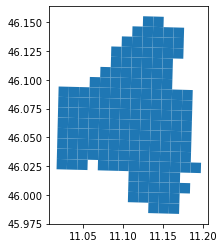

In [107]:
df_grid_trento = df_merged_cg[df_merged_cg['index_com']==131]
df_grid_trento.plot()

In [108]:
df_grid_trento

,cellId,geometry,index_com,COMUNE
1620,4149,"POLYGON ((11.13194 45.99318, 11.14484 45.99294...",131,Trento
1621,4150,"POLYGON ((11.14484 45.99294, 11.15775 45.99270...",131,Trento
1622,4151,"POLYGON ((11.15775 45.99270, 11.17065 45.99246...",131,Trento
1706,4264,"POLYGON ((11.10647 46.00266, 11.11938 46.00242...",131,Trento
1707,4265,"POLYGON ((11.11938 46.00242, 11.13228 46.00218...",131,Trento
...,...,...,...,...
3208,6138,"POLYGON ((11.13784 46.14608, 11.15078 46.14584...",131,Trento
3209,6139,"POLYGON ((11.15078 46.14584, 11.16372 46.14559...",131,Trento
3210,6140,"POLYGON ((11.16372 46.14559, 11.17665 46.14535...",131,Trento
3311,6254,"POLYGON ((11.12524 46.15532, 11.13819 46.15508...",131,Trento


In [109]:
#seleziono da df BIGMERGED (day e night) gli squareid che compongono trento

BIGMERGED_day_tn = BIGMERGED_day[BIGMERGED_day['index_com']==131].reset_index().drop('index', axis=1)
BIGMERGED_night_tn = BIGMERGED_night[BIGMERGED_night['index_com']==131].reset_index().drop('index', axis=1)

In [110]:
BIGMERGED_day_tn

,precipitation,minTemperature,maxTemperature,day,cellId,index_com,COMUNE,index_wstation,station,timestamp,weekday,num_tweets,consumo_ps,index_cons
0,0,-2.6,5.0,2013-11-28,4264.0,131.0,Trento,6,T0129,1385593200,3.0,NaN,25.098184,1.0
1,0,-2.6,5.0,2013-11-28,4265.0,131.0,Trento,6,T0129,1385593200,3.0,NaN,500.385096,2.0
2,0,-2.6,5.0,2013-11-28,4266.0,131.0,Trento,6,T0129,1385593200,3.0,NaN,51.763975,1.0
3,0,-2.6,5.0,2013-11-28,4268.0,131.0,Trento,6,T0129,1385593200,3.0,NaN,4.313665,1.0
4,0,-2.6,5.0,2013-11-28,4381.0,131.0,Trento,6,T0129,1385593200,3.0,NaN,101.965830,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5155,1,9.1,11.9,2013-11-08,6136.0,131.0,Trento,6,T0129,1383865200,4.0,NaN,1334.798194,2.0
5156,1,9.1,11.9,2013-11-08,6137.0,131.0,Trento,6,T0129,1383865200,4.0,NaN,93.877858,1.0
5157,1,9.1,11.9,2013-11-08,6138.0,131.0,Trento,6,T0129,1383865200,4.0,NaN,20.200430,1.0
5158,1,9.1,11.9,2013-11-08,6254.0,131.0,Trento,6,T0129,1383865200,4.0,NaN,75.416951,1.0


In [111]:
from datetime import datetime, timedelta

datetime.strptime(BIGMERGED_day_tn['day'][0], '%Y-%m-%d') - timedelta(days=1)

#in qualche modo riuscirò a creare una funzione che mi tira fuori la riga identificata da stessa cell_id e giornata precedente

datetime.datetime(2013, 11, 27, 0, 0)

In [112]:
#problema rimane capire come attaccare una riga affianco ad un'altra --> disastro xd

In [113]:
#parto dalla colonna day che già posseggo 

df_day = BIGMERGED_day_tn[['day','weekday']]
df_night = BIGMERGED_night_tn[['day','weekday']]


#tengo solo i day che sono compresi tra weekday 2 e 4
df_day = df_day[df_day['weekday'] != 0]
df_day = df_day[df_day['weekday'] != 1]
df_day = df_day.reset_index().drop('index', axis=1)

df_night = df_night[df_night['weekday'] != 0]
df_night = df_night[df_night['weekday'] != 1]
df_night = df_night.reset_index().drop('index', axis=1)

In [114]:
#ora voglio generare una lista con la stessa lunghezza, che al posto di day abbia day-1
day = df_day['day']
night = df_night['day']

In [115]:
#per df giorno

day1d = [] #giorno precedente a day1
for i in range(len(day)):
    day1d.insert(i, (datetime.strptime(day[i], '%Y-%m-%d') - timedelta(days=1)).strftime('%Y-%m-%d'))
     
day2d = [] #giorno precedente a day2
for i in range(len(day)):
    day2d.insert(i, (datetime.strptime(day1d[i], '%Y-%m-%d') - timedelta(days=1)).strftime('%Y-%m-%d'))
    

#per df notte 

day1n = [] #notte precedente a day1
for i in range(len(night)):
    day1n.insert(i, (datetime.strptime(night[i], '%Y-%m-%d') - timedelta(days=1)).strftime('%Y-%m-%d'))
     
day2n = [] #giorno precedente a day2
for i in range(len(day)):
    day2n.insert(i, (datetime.strptime(day1n[i], '%Y-%m-%d') - timedelta(days=1)).strftime('%Y-%m-%d'))

In [116]:
days = pd.DataFrame({'day':day, 'day1':day1d,'day2':day2d})
#di questo df voglio tenere solo alcune righe che mi vadano bene. cioè voglio tenere le righe il cui primo giorno
#sia compreso tra mercoledi e venerdi (in modo da non sfociare nel weekend quando vado indietro di due giorni) -> FATTO SOPRA 
#poi i miei dati partono dal 28 novembre percui voglio eliminare le righe dove day2=27nov/26nov 

nights = pd.DataFrame({'day':day, 'day1':day1n,'day2':day2n})


In [117]:
days = days[days['day2'] != '2013-11-26'] 
days = days[days['day2'] != '2013-11-27']
days= days.groupby(['day','day1','day2']).sum().reset_index()


nights = nights[nights['day2'] != '2013-11-26'] 
nights = nights[nights['day2'] != '2013-11-27']
nights= nights.groupby(['day','day1','day2']).sum().reset_index()

In [118]:
BIGMERGED_day_tn1 = BIGMERGED_day_tn.merge(days, how='left', on='day')
BIGMERGED_day_tn1 = BIGMERGED_day_tn1[BIGMERGED_day_tn1['day2'].notna()]
BIGMERGED_day_tn1

BIGMERGED_night_tn1 = BIGMERGED_night_tn.merge(nights, how='left', on='day')
BIGMERGED_night_tn1 = BIGMERGED_night_tn1[BIGMERGED_night_tn1['day2'].notna()]
BIGMERGED_night_tn1

,precipitation,minTemperature,maxTemperature,day,cellId,index_com,COMUNE,index_wstation,station,timestamp,weekday,num_tweets,consumo_ps,index_cons,day1,day2
258,0,-1.0,10.0,2013-12-06,4264.0,131.0,Trento,6,T0129,1386284400,4.0,NaN,8.928964,1.0,2013-12-05,2013-12-04
259,0,-1.0,10.0,2013-12-06,4265.0,131.0,Trento,6,T0129,1386284400,4.0,NaN,152.785603,1.0,2013-12-05,2013-12-04
260,0,-1.0,10.0,2013-12-06,4266.0,131.0,Trento,6,T0129,1386284400,4.0,NaN,15.805407,1.0,2013-12-05,2013-12-04
261,0,-1.0,10.0,2013-12-06,4268.0,131.0,Trento,6,T0129,1386284400,4.0,NaN,1.317117,1.0,2013-12-05,2013-12-04
262,0,-1.0,10.0,2013-12-06,4381.0,131.0,Trento,6,T0129,1386284400,4.0,NaN,47.586428,1.0,2013-12-05,2013-12-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5155,1,9.1,11.9,2013-11-08,6136.0,131.0,Trento,6,T0129,1383865200,4.0,NaN,481.777405,2.0,2013-11-07,2013-11-06
5156,1,9.1,11.9,2013-11-08,6137.0,131.0,Trento,6,T0129,1383865200,4.0,NaN,28.305793,1.0,2013-11-07,2013-11-06
5157,1,9.1,11.9,2013-11-08,6138.0,131.0,Trento,6,T0129,1383865200,4.0,NaN,11.364014,1.0,2013-11-07,2013-11-06
5158,1,9.1,11.9,2013-11-08,6254.0,131.0,Trento,6,T0129,1383865200,4.0,NaN,34.230367,1.0,2013-11-07,2013-11-06


In [119]:
#ora voglio associare per ogni day1 i dati (sulla stessa riga) che lo riguardano

BIGMERGED_day_tn2 = BIGMERGED_day_tn1.merge(BIGMERGED_day_tn, how='left', right_on=['day','cellId'], left_on=['day1','cellId'])

BIGMERGED_night_tn2 = BIGMERGED_night_tn1.merge(BIGMERGED_night_tn, how='left', right_on=['day','cellId'], left_on=['day1','cellId'])
BIGMERGED_night_tn2


,precipitation_x,minTemperature_x,maxTemperature_x,day_x,cellId,index_com_x,COMUNE_x,index_wstation_x,station_x,timestamp_x,...,day_y,index_com_y,COMUNE_y,index_wstation_y,station_y,timestamp_y,weekday_y,num_tweets_y,consumo_ps_y,index_cons_y
0,0,-1.0,10.0,2013-12-06,4264.0,131.0,Trento,6,T0129,1386284400,...,2013-12-05,131.0,Trento,6,T0129,1386198000,3.0,NaN,9.015045,1.0
1,0,-1.0,10.0,2013-12-06,4265.0,131.0,Trento,6,T0129,1386284400,...,2013-12-05,131.0,Trento,6,T0129,1386198000,3.0,NaN,154.080397,1.0
2,0,-1.0,10.0,2013-12-06,4266.0,131.0,Trento,6,T0129,1386284400,...,2013-12-05,131.0,Trento,6,T0129,1386198000,3.0,NaN,15.939351,1.0
3,0,-1.0,10.0,2013-12-06,4268.0,131.0,Trento,6,T0129,1386284400,...,2013-12-05,131.0,Trento,6,T0129,1386198000,3.0,NaN,1.328279,1.0
4,0,-1.0,10.0,2013-12-06,4381.0,131.0,Trento,6,T0129,1386284400,...,2013-12-05,131.0,Trento,6,T0129,1386198000,3.0,NaN,48.125058,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,1,9.1,11.9,2013-11-08,6136.0,131.0,Trento,6,T0129,1383865200,...,2013-11-07,131.0,Trento,6,T0129,1383778800,3.0,NaN,503.925517,2.0
2834,1,9.1,11.9,2013-11-08,6137.0,131.0,Trento,6,T0129,1383865200,...,2013-11-07,131.0,Trento,6,T0129,1383778800,3.0,NaN,28.324392,1.0
2835,1,9.1,11.9,2013-11-08,6138.0,131.0,Trento,6,T0129,1383865200,...,2013-11-07,131.0,Trento,6,T0129,1383778800,3.0,NaN,11.579355,1.0
2836,1,9.1,11.9,2013-11-08,6254.0,131.0,Trento,6,T0129,1383865200,...,2013-11-07,131.0,Trento,6,T0129,1383778800,3.0,NaN,34.484068,1.0


In [120]:
BIGMERGED_day_tn3 = BIGMERGED_day_tn2.merge(BIGMERGED_day_tn, how='left', right_on=['day','cellId'], left_on=['day2','cellId'])

BIGMERGED_night_tn3 = BIGMERGED_night_tn2.merge(BIGMERGED_night_tn, how='left', right_on=['day','cellId'], left_on=['day2','cellId'])
BIGMERGED_night_tn3


,precipitation_x,minTemperature_x,maxTemperature_x,day_x,cellId,index_com_x,COMUNE_x,index_wstation_x,station_x,timestamp_x,...,day,index_com,COMUNE,index_wstation,station,timestamp,weekday,num_tweets,consumo_ps,index_cons
0,0,-1.0,10.0,2013-12-06,4264.0,131.0,Trento,6,T0129,1386284400,...,2013-12-04,131.0,Trento,6,T0129,1386111600,2.0,NaN,9.280250,1.0
1,0,-1.0,10.0,2013-12-06,4265.0,131.0,Trento,6,T0129,1386284400,...,2013-12-04,131.0,Trento,6,T0129,1386111600,2.0,NaN,157.719815,1.0
2,0,-1.0,10.0,2013-12-06,4266.0,131.0,Trento,6,T0129,1386284400,...,2013-12-04,131.0,Trento,6,T0129,1386111600,2.0,NaN,16.315843,1.0
3,0,-1.0,10.0,2013-12-06,4268.0,131.0,Trento,6,T0129,1386284400,...,2013-12-04,131.0,Trento,6,T0129,1386111600,2.0,NaN,1.359654,1.0
4,0,-1.0,10.0,2013-12-06,4381.0,131.0,Trento,6,T0129,1386284400,...,2013-12-04,131.0,Trento,6,T0129,1386111600,2.0,NaN,49.941266,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,1,9.1,11.9,2013-11-08,6136.0,131.0,Trento,6,T0129,1383865200,...,2013-11-06,131.0,Trento,6,T0129,1383692400,2.0,NaN,499.364232,2.0
2834,1,9.1,11.9,2013-11-08,6137.0,131.0,Trento,6,T0129,1383865200,...,2013-11-06,131.0,Trento,6,T0129,1383692400,2.0,NaN,28.967512,1.0
2835,1,9.1,11.9,2013-11-08,6138.0,131.0,Trento,6,T0129,1383865200,...,2013-11-06,131.0,Trento,6,T0129,1383692400,2.0,NaN,11.562437,1.0
2836,1,9.1,11.9,2013-11-08,6254.0,131.0,Trento,6,T0129,1383865200,...,2013-11-06,131.0,Trento,6,T0129,1383692400,2.0,NaN,33.807118,1.0


In [121]:
#ora droppo un tot di roba che non me serve miga 
#arrivata a questo punto della vita il contrassegno _x indica day, _y indica day1, *nulla* indica day2

BIGMERGED_day_tn4 = BIGMERGED_day_tn3.drop(['day1','day2','station_x','station_y','station','COMUNE_x','COMUNE_y','COMUNE','consumo_ps_x','consumo_ps_y','consumo_ps','day_x','day_y','day','timestamp_y','timestamp','index_com_x','index_com_y','index_com','index_wstation_x','index_wstation_y','index_wstation','weekday_y','weekday'],axis=1)

BIGMERGED_night_tn4 = BIGMERGED_night_tn3.drop(['day1','day2','station_x','station_y','station','COMUNE_x','COMUNE_y','COMUNE','consumo_ps_x','consumo_ps_y','consumo_ps','day_x','day_y','day','timestamp_y','timestamp','index_com_x','index_com_y','index_com','index_wstation_x','index_wstation_y','index_wstation','weekday_y','weekday'],axis=1)


In [122]:
#per ora droppo anche tweets
BIGMERGED_day_tn4 = BIGMERGED_day_tn4.drop(['num_tweets_x','num_tweets_y','num_tweets'], axis=1)

BIGMERGED_night_tn4 = BIGMERGED_night_tn4.drop(['num_tweets_x','num_tweets_y','num_tweets'], axis=1)
BIGMERGED_night_tn4 

,precipitation_x,minTemperature_x,maxTemperature_x,cellId,timestamp_x,weekday_x,index_cons_x,precipitation_y,minTemperature_y,maxTemperature_y,index_cons_y,precipitation,minTemperature,maxTemperature,index_cons
0,0,-1.0,10.0,4264.0,1386284400,4.0,1.0,0,1.8,10.7,1.0,0,0.1,9.0,1.0
1,0,-1.0,10.0,4265.0,1386284400,4.0,1.0,0,1.8,10.7,1.0,0,0.1,9.0,1.0
2,0,-1.0,10.0,4266.0,1386284400,4.0,1.0,0,1.8,10.7,1.0,0,0.1,9.0,1.0
3,0,-1.0,10.0,4268.0,1386284400,4.0,1.0,0,1.8,10.7,1.0,0,0.1,9.0,1.0
4,0,-1.0,10.0,4381.0,1386284400,4.0,1.0,0,1.8,10.7,1.0,0,0.1,9.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,1,9.1,11.9,6136.0,1383865200,4.0,2.0,0,6.1,15.6,2.0,0,7.9,14.3,2.0
2834,1,9.1,11.9,6137.0,1383865200,4.0,1.0,0,6.1,15.6,1.0,0,7.9,14.3,1.0
2835,1,9.1,11.9,6138.0,1383865200,4.0,1.0,0,6.1,15.6,1.0,0,7.9,14.3,1.0
2836,1,9.1,11.9,6254.0,1383865200,4.0,1.0,0,6.1,15.6,1.0,0,7.9,14.3,1.0


In [150]:
BIGMERGED_day_tn4.to_pickle('../data/processed/BIGMERGED_day_tn4.pkl')
BIGMERGED_night_tn4.to_pickle('../data/processed/BIGMERGED_night_tn4.pkl')

Notare come sarebbe necessario One-Hot-Encoding se non fosse già stato eseguito durante la rielaborazione dei dati